In [4]:
!pip install torch
!pip install transformers
!pip install requests

In [2]:

from google.colab import drive
drive.mount('/content/drive')
import os
path = os.path.join('/content/drive/MyDrive/')
path

Mounted at /content/drive


'/content/drive/MyDrive/'

In [5]:
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import models
import requests
from io import StringIO

In [10]:

# Step 1: Load the Data
path = os.path.join('/content/drive/MyDrive/')
# train_df = pd.read_csv(path + 'combined_train.csv')
# test_df = pd.read_csv(path + 'combined_test.csv')
# val_df = pd.read_csv(path + 'combined_val.csv')
#https://drive.google.com/file/d/1ncoP9dP_JEjlOeIiwCM3DWwDVOPUtCDg/view?usp=sharing
#https://drive.google.com/file/d/14ktV6XmTJ9GOZEXJ_8Z5aO57KSTy_LuC/view?usp=sharing
#https://drive.google.com/file/d/1jeklgJ7eyJe_YHMii9RXcXxySIQrTh_O/view?usp=sharing


url = "https://drive.google.com/uc?id=1ncoP9dP_JEjlOeIiwCM3DWwDVOPUtCDg"
response = requests.get(url)
train_df = pd.read_csv(StringIO(response.text))


url = "https://drive.google.com/uc?id=1ncoP9dP_JEjlOeIiwCM3DWwDVOPUtCDg"
response = requests.get(url)
test_df = pd.read_csv(StringIO(response.text))



url = "https://drive.google.com/uc?id=1jeklgJ7eyJe_YHMii9RXcXxySIQrTh_O"
response = requests.get(url)
val_df = pd.read_csv(StringIO(response.text))


In [7]:
import pandas as pd

def tokens_to_df(tokenized_data):
    df = pd.DataFrame({
        'input_ids': [ids.numpy().tolist() for ids in tokenized_data['input_ids']],
        'attention_mask': [mask.numpy().tolist() for mask in tokenized_data['attention_mask']]
    })
    return df

# # Convert the tokenized data to DataFrames
# df_train = tokens_to_df(tokenized_train)
# df_val = tokens_to_df(tokenized_val)
# df_test = tokens_to_df(tokenized_test)

In [15]:
def process_dataframe(df, path):
    image_data = []
    labels = []

    for idx, row in df.iterrows():
        filename = row['filename']
        full_path = os.path.join(path, filename)
        try:
            with Image.open(full_path) as img:
                img_t = transform(img)
                img_t = img_t.view(1, img_t.shape[0], img_t.shape[1], img_t.shape[2])
                image_data.append(img_t)
                labels.append(row['scenic'])
        except Exception as e:
            print(f"Failed to load {filename} due to {e}")

    image_data = torch.cat(image_data)
    labels = torch.tensor(labels, dtype=torch.long)

    return TensorDataset(image_data, labels)


In [13]:
print(train_df['clean_comments'].isnull().sum())  # It should print 0 for all valid entries


1


In [14]:
train_df['clean_comments'].fillna('', inplace=True)


In [16]:

# # Step 2: Process Data
# train_data, df_train = process_dataframe(train_df, path)
# test_data, df_test = process_dataframe(test_df, path)
# val_data, df_val = process_dataframe(val_df, path)


train_data = process_dataframe(train_df, path)
test_data = process_dataframe(test_df, path)
val_data = process_dataframe(val_df, path)


In [17]:

# Step 3: Create Dataloaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [18]:

# Model, Loss, and Optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 317MB/s]


In [19]:

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
loss_values = []
# Step 4: Training Loop
num_epochs = 60
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss/len(train_loader)}")
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)  # Append the average loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

print('Finished Training')

Epoch 1, Loss: 0.5055240337848663
Epoch 1, Loss: 0.5055240337848663
Epoch 2, Loss: 0.3575522531270981
Epoch 2, Loss: 0.3575522531270981
Epoch 3, Loss: 0.32034322535991666
Epoch 3, Loss: 0.32034322535991666
Epoch 4, Loss: 0.29905040860176085
Epoch 4, Loss: 0.29905040860176085
Epoch 5, Loss: 0.28702767777442934
Epoch 5, Loss: 0.28702767777442934
Epoch 6, Loss: 0.2779628703594208
Epoch 6, Loss: 0.2779628703594208
Epoch 7, Loss: 0.27552505445480346
Epoch 7, Loss: 0.27552505445480346
Epoch 8, Loss: 0.2681884481906891
Epoch 8, Loss: 0.2681884481906891
Epoch 9, Loss: 0.2639163362979889
Epoch 9, Loss: 0.2639163362979889
Epoch 10, Loss: 0.26307286739349367
Epoch 10, Loss: 0.26307286739349367
Epoch 11, Loss: 0.256629731297493
Epoch 11, Loss: 0.256629731297493
Epoch 12, Loss: 0.2568952536582947
Epoch 12, Loss: 0.2568952536582947
Epoch 13, Loss: 0.2537415682077408
Epoch 13, Loss: 0.2537415682077408
Epoch 14, Loss: 0.2537066490650177
Epoch 14, Loss: 0.2537066490650177
Epoch 15, Loss: 0.247840008199

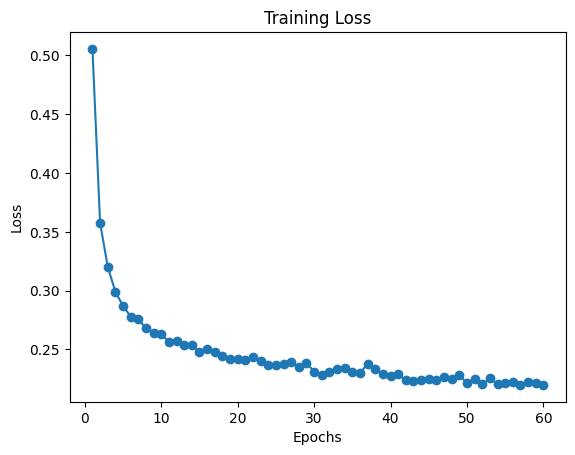

In [21]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs + 1)

plt.plot(epochs_range, loss_values, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [22]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # get the predicted classes
            true_labels.extend(labels.tolist())
            predicted_labels.extend(preds.cpu().tolist())

    return true_labels, predicted_labels

# Get predictions for both test and validation sets
true_labels_train, predicted_labels_train = evaluate_model(model, train_loader, device)

true_labels_test, predicted_labels_test = evaluate_model(model, test_loader, device)
true_labels_val, predicted_labels_val = evaluate_model(model, val_loader, device)


In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


In [24]:
from sklearn.metrics import f1_score

f1_score(true_labels_test, predicted_labels_test, average='macro')

f1_score(true_labels_test, predicted_labels_test, average='micro')

f1_score(true_labels_test, predicted_labels_test, average='weighted')

f1_score(true_labels_test, predicted_labels_test, average=None)

array([0.91518193, 0.91581569])

In [25]:
from sklearn.metrics import classification_report

print(classification_report(true_labels_train, predicted_labels_train))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4000
           1       0.91      0.92      0.92      4000

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000



In [26]:
from sklearn.metrics import classification_report

print(classification_report(true_labels_val, predicted_labels_val))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       500
           1       0.91      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [27]:
def compute_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    return accuracy, conf_matrix, f1

# Compute metrics for test data
accuracy_test, conf_matrix_test, f1_test = compute_metrics(true_labels_test, predicted_labels_test)
print("Test Data Metrics:")
print("Accuracy:", accuracy_test)
print("Confusion Matrix:\n", conf_matrix_test)
print("F1 Score:", f1_test)

# Compute metrics for validation data
accuracy_val, conf_matrix_val, f1_val = compute_metrics(true_labels_val, predicted_labels_val)
print("\nValidation Data Metrics:")
print("Accuracy:", accuracy_val)
print("Confusion Matrix:\n", conf_matrix_val)
print("F1 Score:", f1_val)


Test Data Metrics:
Accuracy: 0.9155
Confusion Matrix:
 [[3647  353]
 [ 323 3677]]
F1 Score: 0.9158156911581569

Validation Data Metrics:
Accuracy: 0.902
Confusion Matrix:
 [[454  46]
 [ 52 448]]
F1 Score: 0.9014084507042253


In [ ]:
# Test Data Metrics:
# Accuracy: 0.903
# Confusion Matrix:
#  [[465  40]
#  [ 57 438]]
# F1 Score: 0.9003083247687566

# Validation Data Metrics:
# Accuracy: 0.901
# Confusion Matrix:
#  [[455  43]
#  [ 56 446]]
# F1 Score: 0.9001009081735621

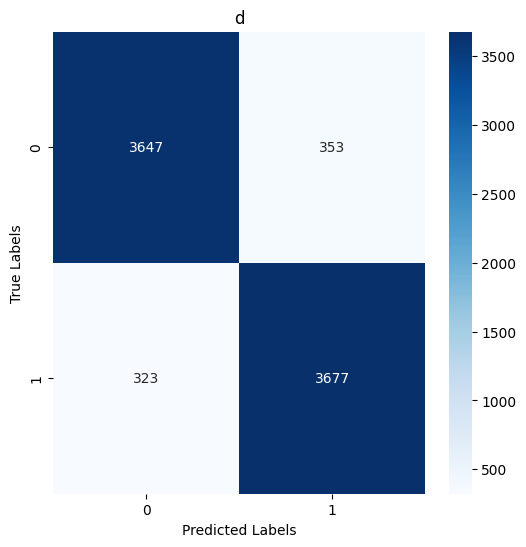

Test Data Metrics:
Accuracy: 0.9155
Confusion Matrix:
 [[3647  353]
 [ 323 3677]]
F1 Score: 0.9158156911581569


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def compute_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    return accuracy, conf_matrix, f1

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix_test, 'd')
# Compute metrics for test data
accuracy_test, conf_matrix_test, f1_test = compute_metrics(true_labels_test, predicted_labels_test)
print("Test Data Metrics:")
print("Accuracy:", accuracy_test)
print("Confusion Matrix:\n", conf_matrix_test)
print("F1 Score:", f1_test)

